## Compute vertical potential vorticity with velocities and density <br>
\begin{equation}
pv = -\frac{g}{\rho_{0}}(f + \zeta)\frac{\partial \rho}{\partial z}
\end{equation}

where $g=9.8 m/s^{2}$; <br> 
$\rho_{0}=1035 kg/m^{3}$; <br>
$\zeta$ is relative vorticity,$\zeta=\frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}$; <br>
$f$ is Coriolis $f = 2\omega sin\theta$, $\omega=7.292e-5$ 

In [1]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
import IPython.display
# import seaborn as sns
from glob import glob
#import scipy as sp
#import scipy.interpolate
#import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings('ignore')
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
import matplotlib
import cftime

In [4]:
WBC=OrderedDict([
    ('eac', {'region':[145-360,174-360,-48,-20], 'x':slice(145-360,174-360),
                    'y': slice(-48,-20)}),
    ('gs',  {'region':[-82,-62,22,46], 'x':slice(-82,-62),
                    'y': slice(22,46)}),
    ('kc',  {'region':[130-360,155-360,28,45], 'x':slice(130-360,155-360),
                    'y': slice(28,45)})
])

In [2]:
session = cc.database.create_session()

In [16]:
PV_good=xr.open_dataarray('PV_reproduced_GSgood.nc')
RV_good=xr.open_dataarray('RV_mean_gsgood.nc')
buofre_good=xr.open_dataarray('buofre_mean_gsgood')
PV_good=xr.open_dataarray('PV_reproduced_GSgood.nc')

In [ ]:
PV=xr.open_dataarray('PV_reproduced_GSbad.nc')

In [3]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [18]:
font={'family':'normal',
     'weight':'bold',
     'size':16}
matplotlib.rc('font',**font)

land=cft.NaturalEarthFeature('physical','land','110m',
                            edgecolor='black',facecolor='gray',
                            linewidth=0.5)

## calculate vertical potential vorticity with velicities and density
1. Relative vorticity
\begin{equation}
\begin{aligned}
\zeta=&\frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}\\
     =&-\frac{1}{2}[\frac{u(i,j,k)-u(i,j-1,k)}{dy}+\frac{u(i-1,j,k)-u(i-1,j-1,k)}{dy}]\\
      &+\frac{1}{2}[\frac{v(i,j,k)-v(i-1,j,k)}{dx}+\frac{v(i-1,j-1,k)-v(i,j-1,k)}{dx}]
\end{aligned}
\end{equation}


2. Vertical density gradient
\begin{equation}
\begin{aligned}
\frac{\partial \rho}{\partial z}&=\frac{\Delta \rho}{\Delta z}\\
&=\frac{\rho(i,j,k)-\rho(i,j,k-1)}{dz}\\
& = \frac{\rho(i,j,k)-\rho(i,j,k-1)}{st\_ocean(i,j,k)-st\_ocean(i,j,k-1)}
\end{aligned}
\end{equation}

where $\rho$ is potential density reference to 2000 dbar



computational process of RV is shown in the diagram. Since velocities are stored in ucell while dxt,dyt and density is stored in tcell, tcell arrays are trimmed to be consistent with ucell arrays 

![title](RV1.pdf)

![title](RV2.pdf)

In [11]:
def PV_separation_input(time,ekey,wbc):
    expt=exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    offset = exptdata.exptdict[ekey]['offset']
    
    region=WBC[wbc]['region']
    wbcx=WBC[wbc]['x']
    wbcy=WBC[wbc]['y']
    
    print('loading density...')
    rho=cc.querying.getvar(expt,'pot_rho_2',session,
                                 n=n_files,offset=offset)\
                                 .sel(xt_ocean=wbcx)\
                                 .sel(yt_ocean=wbcy)\
                                 .sel(time=time)
    print('loading u...')
    u=cc.querying.getvar(expt,'u',session,
                                 n=n_files,offset=offset)\
                                 .sel(xu_ocean=wbcx)\
                                 .sel(yu_ocean=wbcy)\
                                 .sel(time=time)
    print('loading v...')
    v=cc.querying.getvar(expt,'v',session,
                                 n=n_files,offset=offset)\
                                 .sel(xu_ocean=wbcx)\
                                 .sel(yu_ocean=wbcy)\
                                 .sel(time=time)
    return rho,u,v

## Good separation period (1985-2009)

time-mean relative vorticity:
\begin{equation}
\overline{\zeta}=\overline{\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y}}
\end{equation}
time-mean density gradient:
\begin{equation}
\overline{\frac{\partial \rho}{\partial z}}
\end{equation}
time-mean reproduced pv:
\begin{equation}
\overline{-\frac{g}{\rho_{0}}(\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y}+f)\frac{\partial \rho}{\partial z}}
\end{equation}

RV: year-mean relative vorticity: $\overline{\zeta} =\overline{ -\frac{\partial u}{\partial y}+\frac{\partial v}{\partial x}}$ <br>
buofre: year-mean vertical density gradient $\overline{\frac{\partial \rho}{\partial z}}$ <br>
PV:year-mean vertical potential vorticity (computed with velocities and density)$\overline{-\frac{g}{\rho_0}(f+\zeta)\frac{\partial \rho}{\partial z}}$

In [12]:
warnings.filterwarnings('ignore')
time=slice('1985-01-01','2009-01-01')
rho,u,v=PV_separation_input(time,'01deg','gs')

loading density...
loading u...
loading v...


In [14]:
region=WBC['gs']['region']
wbcx=WBC['gs']['x']
wbcy=WBC['gs']['y']
grid = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output120/ocean/ocean_grid.nc')
dyt=grid.dyt.sel(xt_ocean=wbcx)\
        .sel(yt_ocean=wbcy)
dxt=grid.dxt.sel(xt_ocean=wbcx)\
        .sel(yt_ocean=wbcy)
dytnew=dyt[:,1:]
dxtnew=dxt[:,1:]

In [27]:
#pv separation in 01deg
def PV_separation(u_whole,v_whole,rho_whole):
    ysize=rho_whole.shape[2]
    xsize=rho_whole.shape[3]-1
    zsize=rho_whole.shape[1]
    z=rho_whole.st_ocean.values# z axes of tcell
    dz=z[1:]-z[0:-1]# compute height of grid with st_ocean
    dz3d=np.tile(dz,(ysize,xsize,1))
    dz3dd=np.transpose(dz3d,(2,0,1))# make it a 3d array
    dytnew3d=np.tile(dytnew.values,(zsize,1,1))
    dxtnew3d=np.tile(dxtnew.values,(zsize,1,1))
    ##pre assign 3d arrays to store year-mean rv, dendity gradient and pv
    zeta_whole=np.zeros((zsize,ysize,xsize),dtype='int')
    rho_grad_whole=np.zeros((zsize-1,ysize,xsize),dtype='int')
    pv_rep_whole=np.zeros((zsize-1,ysize,xsize))
    realrv_whole=np.zeros((zsize-1,ysize,xsize))
    planetary_whole=np.zeros((zsize-1,ysize,xsize))
    #Coriolis
    theta=dytnew['yt_ocean']*math.pi/180
    omega=7.292e-5
    f=2*omega*np.sin(theta)
    f3d=np.tile(f,(74,xsize,1))
    f3dd=np.transpose(f3d,(0,2,1))# make it a 3d array
    Coriolis=xr.DataArray(f3dd,
                        coords=[rho_whole['st_ocean'][0:-1],
                                dytnew['yt_ocean'],dytnew['xt_ocean']])
    T=len(rho_whole['time'])
    for m in range(0,T):
        print('computing',str(m+1),'in',str(T))
        rho = rho_whole.isel(time=m)[:,:,1:]
        u = u_whole.isel(time=m)
        v = v_whole.isel(time=m)
        #Relative vorticity every month
        dv = v.values[:,:,1:]-v.values[:,:,0:-1]
        dv_mean=1/2*(dv[:,1:,:]+dv[:,0:-1,:])
        dv_dx_mean = dv_mean/dxtnew3d
        du = u.values[:,1:,:]-u.values[:,0:-1,:]
        du_mean=1/2*(du[:,:,1:]+du[:,:,0:-1])
        du_dy_mean = du_mean/dytnew3d
        zeta = dv_dx_mean-du_dy_mean
        
        #density gradient every month
        drho=rho.values[0:-1,:,:]-rho.values[1:75,:,:]
        drho_dz=drho/dz3dd
        # potential vorticity (computed with density and velocities) every month
        pv_rep=-9.8/1035*(f3dd+zeta[0:-1])*drho_dz
        realrv=-9.8/1035*(zeta[0:-1])*drho_dz
        planetary=-9.8/1035*(f3dd)*drho_dz
        #year-mean relative vorticity
        zeta_whole=zeta_whole+zeta/T
        rho_grad_whole=rho_grad_whole+drho_dz/T
        pv_rep_whole=pv_rep_whole+pv_rep/T
        realrv_whole=realrv_whole+realrv/T
        planetary_whole=planetary_whole+planetary/T
    RV=xr.DataArray(zeta_whole
                    ,coords=[v['st_ocean'],dytnew['yt_ocean'],dytnew['xt_ocean']])
    buofre=xr.DataArray(rho_grad_whole,
                        coords=[v['st_ocean'][0:-1],
                                dytnew['yt_ocean'],dytnew['xt_ocean']])
    PV = xr.DataArray(pv_rep_whole,
                        coords=[v['st_ocean'][0:-1],
                                dytnew['yt_ocean'],dytnew['xt_ocean']])
    RealRV=xr.DataArray(realrv_whole,
                        coords=[v['st_ocean'][0:-1],
                                dytnew['yt_ocean'],dytnew['xt_ocean']])
    Planetary=xr.DataArray(planetary_whole,
                        coords=[v['st_ocean'][0:-1],
                                dytnew['yt_ocean'],dytnew['xt_ocean']])
    return RV,buofre,PV,RealRV,Planetary
    

In [15]:
RV_good,buofre_good,PV_good,RealRV_good,Planetary_good=PV_separation(u,v,rho)

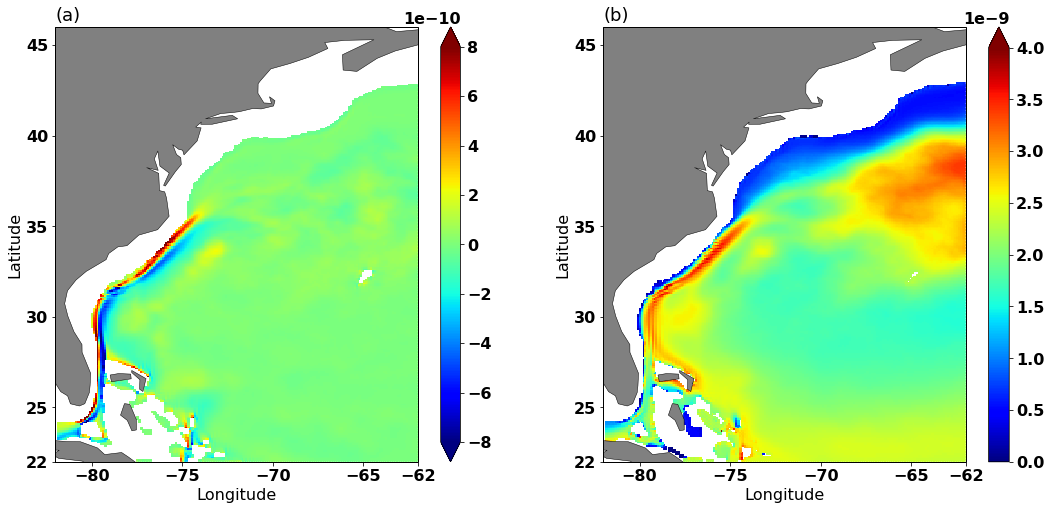

In [24]:
fig=plt.figure(figsize=(18,8))
ax0=fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
ax0.set_extent([-82,-62, 22,46], crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks([-80,-75,-70,-65,-62], crs=ccrs.PlateCarree())
ax0.set_yticks([22,25,30,35,40,45], crs=ccrs.PlateCarree())
p3=RealRV_good.sel(st_ocean=400,method='nearest').plot(cmap='jet',vmin=-8e-10,vmax=8e-10,add_colorbar=True)
#cb3=fig.colorbar(p3)
#cb3.ax.set_ylabel('s$^{-3}$',fontsize=18)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(a)',loc='left',fontsize=18)


ax0=fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())
ax0.set_extent([-82,-62, 22,46], crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks([-80,-75,-70,-65,-62], crs=ccrs.PlateCarree())
ax0.set_yticks([22,25,30,35,40,45], crs=ccrs.PlateCarree())
p4=Planetary_good.sel(st_ocean=400,method='nearest').plot(cmap='jet',vmin=0,vmax=4e-09,add_colorbar=True)
#cb4=fig.colorbar(p4)
#cb4.ax.set_ylabel('s$^{-3}$',fontsize=18)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(b)',loc='left',fontsize=18)
savefigure('rvandrho_gs')

In [15]:
PV.to_netcdf('PV_reproduced_GSgood.nc')

## plot part of potential vorticity vs model diag for good separation period

In [17]:
# load model diagnostic 'vert_pv' for year 2017 (year-mean)
ekey='01deg'
expt=exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
offset = exptdata.exptdict[ekey]['offset']
pv_good=cc.querying.getvar(expt,'vert_pv',session,
                     n=n_files,offset=offset)\
                     .sel(xt_ocean=wbcx)\
                     .sel(yt_ocean=wbcy)\
                     .sel(time=time).mean('time')

Text(0,1,'(d)')

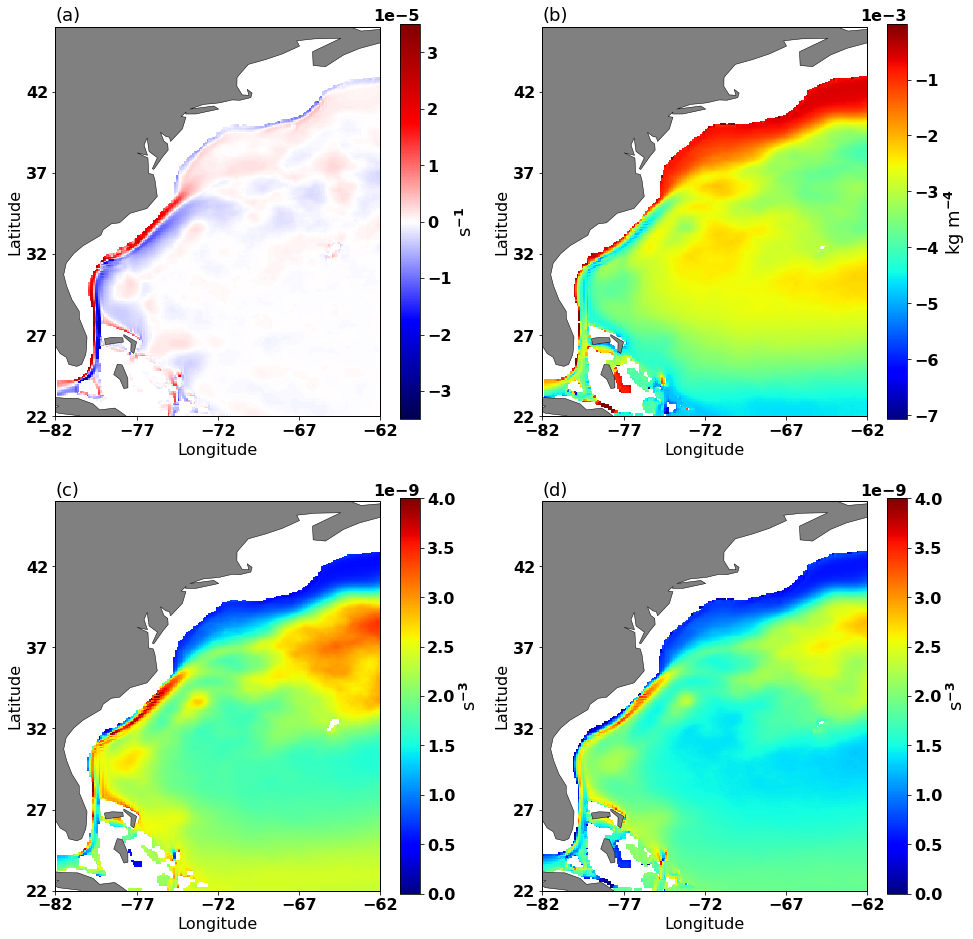

In [22]:
warnings.filterwarnings('ignore')
#RV_good=RV
#buofre_good=buofre
#PV_good=PV
d=400
fig=plt.figure(figsize=(16,16))
ax0=fig.add_subplot(2,2,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5), crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
p1=plt.pcolormesh(RV_good['xt_ocean'],RV_good['yt_ocean'],
                  RV_good.sel(st_ocean=d,method='nearest'),cmap='seismic',vmin=-3.5e-5,vmax=3.5e-5)
cb1=fig.colorbar(p1)
cb1.formatter.set_powerlimits((0, 0))
cb1.update_ticks()
cb1.ax.set_ylabel('s$^{-1}$',fontsize=18)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(a)',loc='left',fontsize=18)

ax0=fig.add_subplot(2,2,2,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5), crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
p2=plt.pcolormesh(buofre_good['xt_ocean'],buofre_good['yt_ocean'],
               buofre_good.sel(st_ocean=d,method='nearest').values
              ,cmap='jet')
cb2=fig.colorbar(p2)
cb2.ax.set_ylabel('kg m$^{-4}$',fontsize=18)
cb2.formatter.set_powerlimits((0, 0))
cb2.update_ticks()
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(b)',loc='left',fontsize=18)


ax0=fig.add_subplot(2,2,3,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5), crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
p3=PV_good.sel(st_ocean=d,method='nearest').plot(cmap='jet',vmin=0,vmax=4e-09,add_colorbar=False)
cb3=fig.colorbar(p3)
cb3.ax.set_ylabel('s$^{-3}$',fontsize=18)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(c)',loc='left',fontsize=18)


ax0=fig.add_subplot(2,2,4,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5), crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
p4=pv_good.sel(st_ocean=d,method='nearest').plot(cmap='jet',vmin=0,vmax=4e-09,add_colorbar=False)
cb4=fig.colorbar(p4)
cb4.ax.set_ylabel('s$^{-3}$',fontsize=18)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(d)',loc='left',fontsize=18)
#savefigure('pv_sep_GFS_good')

## Bad separation period

In [25]:
warnings.filterwarnings('ignore')
time=slice('2009-01-01','2018-01-01')
rho,u,v=PV_separation_input(time,'01deg','gs')
rho,u,v=PV_separation_input(time,'01deg','gs')

loading density...
loading u...
loading v...
loading density...
loading u...
loading v...


In [29]:
RV_bad,buofre_bad,PV_bad,RealRV_bad,Planetary_bad=PV_separation(u,v,rho)

In [12]:
PV.to_netcdf('PV_reproduced_GSbad.nc')
RV.to_netcdf('RV_mean_gsbad.nc')
buofre.to_netcdf('buofre_mean_gsbad')

## plot part of potential vorticity vs model diag for bad separation period

In [ ]:
PV=xr.open_dataarray('PV_reproduced_GSbad.nc')
RV=xr.open_dataarray('RV_mean_gsbad.nc')
buofre=xr.open_dataarray('buofre_mean_gsbad')

In [30]:
ekey='01deg'
expt=exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
offset = exptdata.exptdict[ekey]['offset']
pv=cc.querying.getvar(expt,'vert_pv',session,
                     n=n_files,offset=offset)\
                     .sel(xt_ocean=wbcx)\
                     .sel(yt_ocean=wbcy)\
                     .sel(time=time).mean('time')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


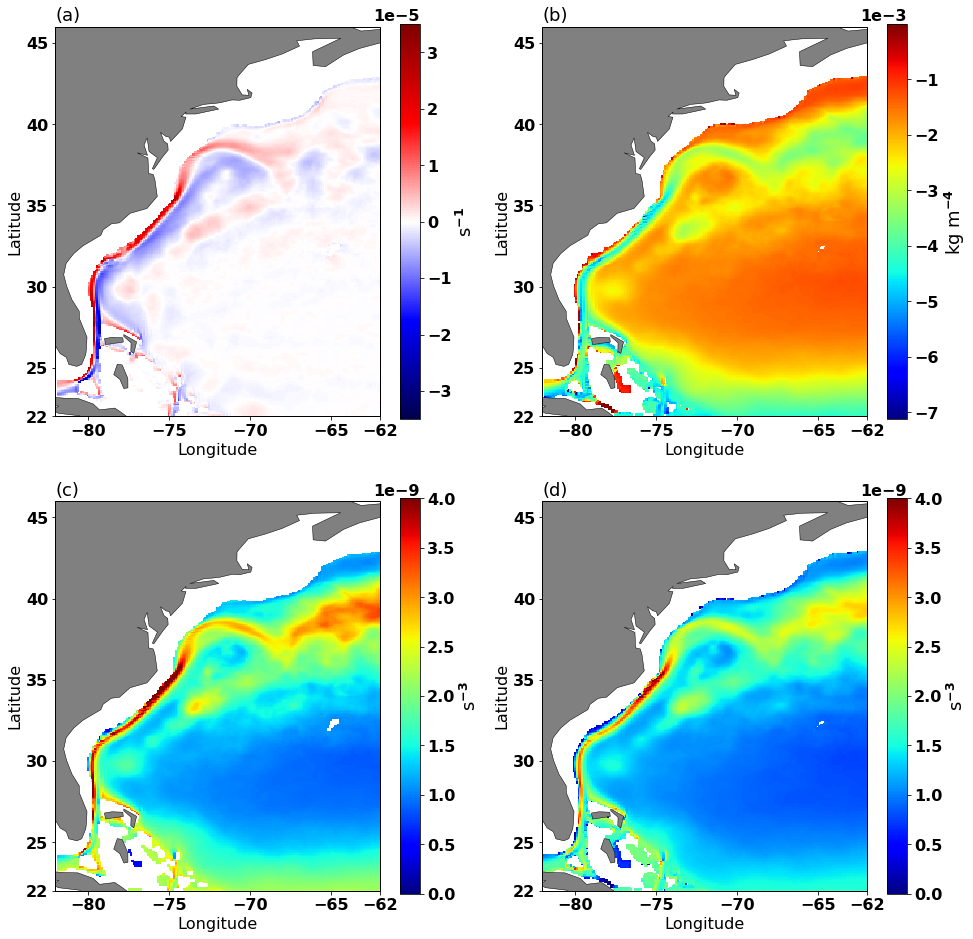

In [16]:
warnings.filterwarnings('ignore')
fig=plt.figure(figsize=(16,16))
ax0=fig.add_subplot(2,2,1,projection=ccrs.PlateCarree())
ax0.set_extent([-82,-62, 22,46], crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks([-80,-75,-70,-65,-62], crs=ccrs.PlateCarree())
ax0.set_yticks([22,25,30,35,40,45], crs=ccrs.PlateCarree())
p1=plt.pcolormesh(RV['xt_ocean'],RV['yt_ocean'],
                  RV.sel(st_ocean=400,method='nearest'),cmap='seismic',vmin=-3.5e-5,vmax=3.5e-5)
cb1=fig.colorbar(p1)
cb1.formatter.set_powerlimits((0, 0))
cb1.ax.set_ylabel('s$^{-1}$',fontsize=18)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(a)',loc='left',fontsize=18)

ax0=fig.add_subplot(2,2,2,projection=ccrs.PlateCarree())
ax0.set_extent([-82,-62, 22,46], crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks([-80,-75,-70,-65,-62], crs=ccrs.PlateCarree())
ax0.set_yticks([22,25,30,35,40,45], crs=ccrs.PlateCarree())
p2=plt.pcolormesh(buofre['xt_ocean'],buofre['yt_ocean'],
               buofre.sel(st_ocean=400,method='nearest').values
              ,cmap='jet')
cb2=fig.colorbar(p2)
cb2.ax.set_ylabel('kg m$^{-4}$',fontsize=18)
cb2.formatter.set_powerlimits((0, 0))
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(b)',loc='left',fontsize=18)


ax0=fig.add_subplot(2,2,3,projection=ccrs.PlateCarree())
ax0.set_extent([-82,-62, 22,46], crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks([-80,-75,-70,-65,-62], crs=ccrs.PlateCarree())
ax0.set_yticks([22,25,30,35,40,45], crs=ccrs.PlateCarree())
p3=PV.sel(st_ocean=400,method='nearest').plot(cmap='jet',vmin=0,vmax=4e-09,add_colorbar=False)
cb3=fig.colorbar(p3)
cb3.ax.set_ylabel('s$^{-3}$',fontsize=18)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(c)',loc='left',fontsize=18)


ax0=fig.add_subplot(2,2,4,projection=ccrs.PlateCarree())
ax0.set_extent([-82,-62, 22,46], crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks([-80,-75,-70,-65,-62], crs=ccrs.PlateCarree())
ax0.set_yticks([22,25,30,35,40,45], crs=ccrs.PlateCarree())
p4=pv.sel(st_ocean=400,method='nearest').plot(cmap='jet',vmin=0,vmax=4e-09,add_colorbar=False)
cb4=fig.colorbar(p4)
cb4.ax.set_ylabel('s$^{-3}$',fontsize=18)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(d)',loc='left',fontsize=18)
#savefigure('pv_sep_GFS_bad')

Text(0,1,'(b)')

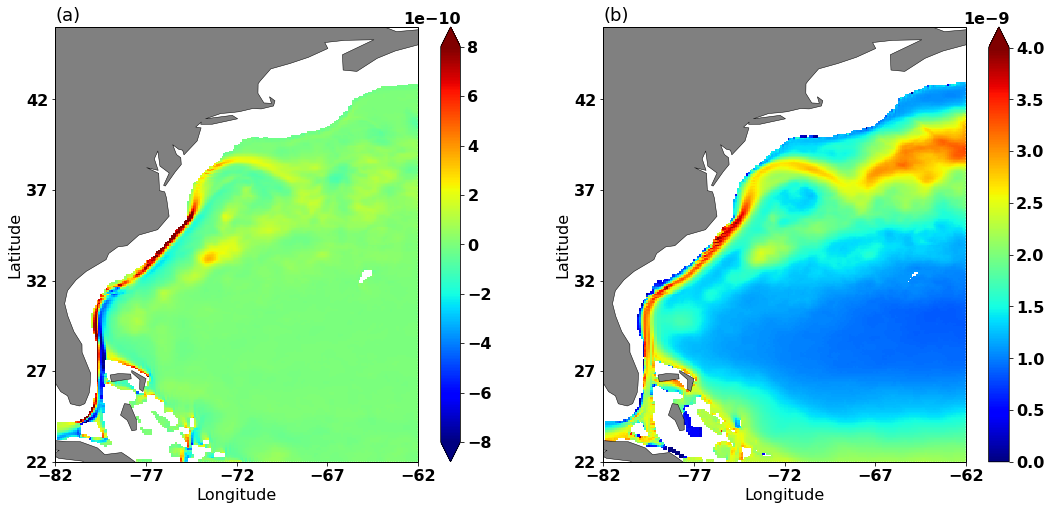

In [31]:
warnings.filterwarnings('ignore')
d=400
fig=plt.figure(figsize=(18,8))
ax0=fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5), crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
p3=RealRV_bad.sel(st_ocean=d,method='nearest').plot(cmap='jet',vmin=-8e-10,vmax=8e-10,add_colorbar=True)
#cb3=fig.colorbar(p3)
#cb3.ax.set_ylabel('s$^{-3}$',fontsize=18)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(a)',loc='left',fontsize=18)


ax0=fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5), crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
p4=Planetary_bad.sel(st_ocean=d,method='nearest').plot(cmap='jet',vmin=0,vmax=4e-09,add_colorbar=True)
#cb4=fig.colorbar(p4)
#cb4.ax.set_ylabel('s$^{-3}$',fontsize=18)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(b)',loc='left',fontsize=18)
#savefigure('rvandrho_gs')